## Obtaining the predictors
In this case we will bring all the variables to start working with everything.
### The fast forward way!
It now includes population


In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
#from drivers.tree_builder import TreeNeo
#from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
#from drivers.graph_models import Cell,Mex4km, countObjectsOf
#from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
#import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

In [2]:
#from raster_api.tools import RasterData
from raster_api.models import raster_models as models
#from sketches.models import Country
#from mesh.models import MexMesh
#from ecoregions.models import TerrEcoregions,InegiIV


## Rebuilding polygons from obtained pseudio absences

In [3]:
from django.contrib.gis.geos import Point, Polygon
xcoord = -99.76
ycoord = 17.55
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,1, 10)
polys = map(lambda r : p.buffer(r),radii)


In [4]:
import utilities.data_extraction as de

In [5]:
tiki = de.compilePredictorStack(polys[0],0.05,models)

In [6]:
dfs = map(lambda t : t.toPandasDataFrame(),tiki)

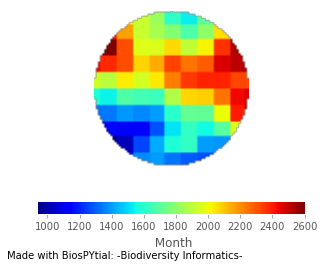

In [9]:
t.display_field()

In [ ]:
datadict = { key : RasterData(models[key],border=polys[4],name=key) for key,value in models.iteritems()}
## Without resamling (whole data)
pixel_size = 0.05


In [ ]:
wp = datadict['WorldPopLatam2010']
prec = datadict['Precipitation']
wp.rescale(pixel_size,algorithm='Cubic')
prec.rescale(pixel_size,algorithm='Cubic')

In [ ]:
wp_df1 = wp.toPandasDataFrame(aggregate_with_mean=False)

In [ ]:
prec_df1 = prec.toPandasDataFrame(aggregate_with_mean=True)

In [ ]:
wp_df2 = compileDataCube(pixel_size=pixel_size,polygon_border=polys[4])

In [ ]:
prec_df2 = compileDataCube(pixel_size=pixel_size,polygon_border=polys[4])

In [ ]:
prec_df1.columns

In [ ]:
%%time
def extractVegetation(list_points):
    """
    Given a list of points it will return a dataframe of the corresponding vegetation 
    type from the TerrEcoregions and INEGI series V.
    To be included in data extraction method, but there's no time for it, there's never time for anything!
    Returns a dataframe.
    """
    points = list_points
    ecoregions = map(lambda p : TerrEcoregions.objects.filter(geom__intersects=p),points)
    ecovalues = map(lambda q : q.values_list('wwf_mhtnum','wwf_mhtnam'),ecoregions)
    inegiregions = map(lambda p : InegiIV.objects.filter(geom__intersects=p),points)
    inegivalues = map(lambda q : q.values_list('covid','name'),inegiregions)
    ecovals = [r.get() if r.exists() else (np.nan,'NaN') for r in ecovalues ]
    inegivals = [r.get() if r.exists() else (np.nan,'NaN') for r in inegivalues ]
    # Compile dataframe
    vegdat = pd.DataFrame(ecovals)
    inegidat = pd.DataFrame(inegivals)
    vegdat.columns = ['vegid','vegname']
    inegidat.columns = ['inegiv5id','inegiv5name']
    results = pd.concat([vegdat,inegidat],axis=1)
    return results

In [ ]:
def compileDataCube(pixel_size,polygon_border):
    datadict = { key : RasterData(models[key],border=polygon_border) for key,value in models.iteritems()}
    datacube_field = map(lambda raster : raster.rescale(pixel_size,algorithm='Cubic'),datadict.itervalues())
    datacube = datacube_field
    cubes = map(lambda (k,v): np.mean(v.toNumpyArray(),axis=0), datadict.iteritems())
    extractCoords = lambda (k,v) : v.getCoordinates() 
    lcoords = map(extractCoords,datadict.iteritems())
    coords = lcoords[0]
    ## Oke I need a way to extract the dataframe, maybe aggregate it by mean 
    dataframe_cube = map(lambda cube: pd.DataFrame(cube.flatten()),cubes)
    datacube = pd.concat(dataframe_cube,axis=1)
    datacube = pd.concat([datacube,coords],axis=1)
    datacube.columns = datadict.keys() + list(coords.columns)
    
    toPoint = lambda r : Point(tuple(r))
    points = coords.apply(toPoint,axis=1)
    vegdf = extractVegetation(points)
    predictors = pd.concat([datacube,vegdf],axis=1)
    return {'raster_dic':datadict, 'pred_df':predictors}

In [ ]:
### Do all this for all the polygons
predictors_dataframes = map(lambda p : compileDataCube(pixel_size=pixel_size,polygon_border=p),polys)

In [ ]:
dataframes = map(lambda p : p['pred_df'],predictors_dataframes)

## Let´s save it for the posterity
We need to encode the name into utf8, because.... python 2 !! 

In [ ]:
for i,d in enumerate(dataframes):
    cad = '/outputs/presence_only_models/predictors/pred-%s.csv'%i
    print(cad)
    d.to_csv(cad,encoding='utf8')